# Run Third Model

In [1]:
import pathlib
import sys
import pickle

from typing import List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno

%matplotlib inline

# Load the "autoreload" extension
%load_ext autoreload
# always reload modules marked with "%aimport"
%autoreload 1
# add the 'src' directory to path to import modules
src_dir = pathlib.Path().cwd().resolve().parent / 'src'
#src_dir = os.path.join(os.getcwd(), os.pardir, 'src')
sys.path.append(str(src_dir))
# import my class code from the source
# %aimport src-dir.filename
from data.data_process import transform_ts_to_supervised

from skoot.preprocessing import SelectiveMinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

from xgboost import XGBClassifier

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
np.set_printoptions(suppress=True)

PROJECT_DIR = pathlib.Path.cwd().resolve().parent
CONSOL_DATA_DIR = PROJECT_DIR / 'data' / '07-consolidated'

In [2]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

In [3]:
def rps_mean(estimator, X: np.ndarray, y: np.ndarray) -> float:
    """
    https://scikit-learn.org/stable/modules/model_evaluation.html#implementing-your-own-scoring-object
    Accepts:
    a scikit learn estimator model - estimator must have a predict_proba method
    X - data used to make prediction - validation data
    y = ground truth
    
    !!!!!!!!!!!
    """
    # Convert the y to a one hot encoded DataFrame in same sequence as prediction probas
    
    # Deal with situation where all classes not in y
    # Get the missing classes
    missing_classes = set(estimator.classes_) - set(y.unique())
    # Get ys as a DataFrame
    y_encoded = pd.get_dummies(y)
    if missing_classes:
        for missing_class in missing_classes:
            # Insert missing class into y encoded as 0
            y_encoded[missing_class] = 0
            
    # Put y matrix into the same column order as the probability predictions
    y_encoded = y_encoded[estimator.classes_]
        
    # Get the probabilities into a DataFrame
    pred_df = pd.DataFrame(estimator.predict_proba(X))
    
    # Cumulative Distributions
    pred_cdf = pd.DataFrame(pred_df).cumsum(axis='columns').values
    obs_cdf = y_encoded.cumsum(axis='columns').values
    # RPS Calculation and get sum
    # each prediction set could be a different length, so divide the sum by the number of pred observations
    #RPS = pd.Series(np.sum(1/(pred_df.shape[1]-1) * (pred_cdf - obs_cdf)**2, 1), name='RPS').sum()/len(y)
    mean_RPS = pd.Series(np.sum(1/(pred_df.shape[1]-1) * (pred_cdf - obs_cdf)**2, 1), name='RPS').mean()
    # Negate return because for RPS lower is better, but for sklearn scorer higher is better
    return -mean_RPS

### Load & Review Data

In [4]:
fp = CONSOL_DATA_DIR / 'epl.csv'
df = pd.read_csv(fp, index_col=None)

In [5]:
df.head()

,nation,league,season,date,h,a,h_ftGoals,a_ftGoals,h_corners,h_fouls,h_redCards,h_shots,h_shotsOnTarget,h_htGoals,h_yellowCards,a_corners,a_fouls,a_redCards,a_shots,a_shotsOnTarget,a_htGoals,a_yellowCards,h_oddsWinMean,h_oddsDrawMean,a_oddsWinMean,oddsHwinBet,oddsDrawBet,oddsAwinBet,oddsHwinPinn,oddsDrawPinn,oddsAwinPinn,oddsHwinMax,oddsDrawMax,oddsAwinMax,result,h_result,a_result,h_goalsFor,h_goalsAgainst,a_goalsFor,a_goalsAgainst,h_impliedWinProbMean,h_impliedDrawProbMean,a_impliedDrawProbMean,a_impliedWinProbMean,a_oddsDrawMean,h_h_ftGoals-0,h_h_ftGoals-1,h_h_ftGoals-2,h_h_ftGoals-3,h_h_ftGoals-4,h_h_ftGoals-5,h_h_ftGoals-6,h_h_ftGoals-7,h_h_ftGoals-8,h_h_ftGoals-9,h_h_ftGoals-10,h_h_ftGoals-11,h_h_ftGoals-12,h_h_ftGoals-13,h_h_ftGoals-14,h_h_ftGoals-15,h_h_ftGoals-16,h_h_ftGoals-17,h_h_ftGoals-18,a_a_ftGoals-0,a_a_ftGoals-1,a_a_ftGoals-2,a_a_ftGoals-3,a_a_ftGoals-4,a_a_ftGoals-5,a_a_ftGoals-6,a_a_ftGoals-7,a_a_ftGoals-8,a_a_ftGoals-9,a_a_ftGoals-10,a_a_ftGoals-11,a_a_ftGoals-12,a_a_ftGoals-13,a_a_ftGoals-14,a_a_ftGoals-15,a_a_ftGoals-16,a_a_ftGoals-17,a_a_ftGoals-18,a_h_ftGoals-1,a_h_ftGoals-10,a_h_ftGoals-11,a_h_ftGoals-12,a_h_ftGoals-13,a_h_ftGoals-14,a_h_ftGoals-15,a_h_ftGoals-16,a_h_ftGoals-17,a_h_ftGoals-18,a_h_ftGoals-19,a_h_ftGoals-2,a_h_ftGoals-3,a_h_ftGoals-4,a_h_ftGoals-5,a_h_ftGoals-6,a_h_ftGoals-7,a_h_ftGoals-8,a_h_ftGoals-9,h_a_ftGoals-1,h_a_ftGoals-10,h_a_ftGoals-11,h_a_ftGoals-12,h_a_ftGoals-13,h_a_ftGoals-14,h_a_ftGoals-15,h_a_ftGoals-16,h_a_ftGoals-17,h_a_ftGoals-18,h_a_ftGoals-19,h_a_ftGoals-2,h_a_ftGoals-3,h_a_ftGoals-4,h_a_ftGoals-5,h_a_ftGoals-6,h_a_ftGoals-7,h_a_ftGoals-8,h_a_ftGoals-9,h_h_shots-0,h_h_shots-1,h_h_shots-2,h_h_shots-3,h_h_shots-4,h_h_shots-5,h_h_shots-6,h_h_shots-7,h_h_shots-8,h_h_shots-9,h_h_shots-10,h_h_shots-11,h_h_shots-12,h_h_shots-13,h_h_shots-14,h_h_shots-15,h_h_shots-16,h_h_shots-17,h_h_shots-18,a_a_shots-0,a_a_shots-1,a_a_shots-2,a_a_shots-3,a_a_shots-4,a_a_shots-5,a_a_shots-6,a_a_shots-7,a_a_shots-8,a_a_shots-9,a_a_shots-10,a_a_shots-11,a_a_shots-12,a_a_shots-13,a_a_shots-14,a_a_shots-15,a_a_shots-16,a_a_shots-17,a_a_shots-18,a_h_shots-1,a_h_shots-10,a_h_shots-11,a_h_shots-12,a_h_shots-13,a_h_shots-14,a_h_shots-15,a_h_shots-16,a_h_shots-17,a_h_shots-18,a_h_shots-19,a_h_shots-2,a_h_shots-3,a_h_shots-4,a_h_shots-5,a_h_shots-6,a_h_shots-7,a_h_shots-8,a_h_shots-9,h_a_shots-1,h_a_shots-10,h_a_shots-11,h_a_shots-12,h_a_shots-13,h_a_shots-14,h_a_shots-15,h_a_shots-16,h_a_shots-17,h_a_shots-18,h_a_shots-19,h_a_shots-2,h_a_shots-3,h_a_shots-4,h_a_shots-5,h_a_shots-6,h_a_shots-7,h_a_shots-8,h_a_shots-9,h_h_shotsOnTarget-0,h_h_shotsOnTarget-1,h_h_shotsOnTarget-2,h_h_shotsOnTarget-3,h_h_shotsOnTarget-4,h_h_shotsOnTarget-5,h_h_shotsOnTarget-6,h_h_shotsOnTarget-7,h_h_shotsOnTarget-8,h_h_shotsOnTarget-9,h_h_shotsOnTarget-10,h_h_shotsOnTarget-11,h_h_shotsOnTarget-12,h_h_shotsOnTarget-13,h_h_shotsOnTarget-14,h_h_shotsOnTarget-15,h_h_shotsOnTarget-16,h_h_shotsOnTarget-17,h_h_shotsOnTarget-18,a_a_shotsOnTarget-0,a_a_shotsOnTarget-1,a_a_shotsOnTarget-2,a_a_shotsOnTarget-3,a_a_shotsOnTarget-4,a_a_shotsOnTarget-5,a_a_shotsOnTarget-6,a_a_shotsOnTarget-7,a_a_shotsOnTarget-8,a_a_shotsOnTarget-9,a_a_shotsOnTarget-10,a_a_shotsOnTarget-11,a_a_shotsOnTarget-12,a_a_shotsOnTarget-13,a_a_shotsOnTarget-14,a_a_shotsOnTarget-15,a_a_shotsOnTarget-16,a_a_shotsOnTarget-17,a_a_shotsOnTarget-18,a_h_shotsOnTarget-1,a_h_shotsOnTarget-10,a_h_shotsOnTarget-11,a_h_shotsOnTarget-12,a_h_shotsOnTarget-13,a_h_shotsOnTarget-14,a_h_shotsOnTarget-15,a_h_shotsOnTarget-16,a_h_shotsOnTarget-17,a_h_shotsOnTarget-18,a_h_shotsOnTarget-19,a_h_shotsOnTarget-2,a_h_shotsOnTarget-3,a_h_shotsOnTarget-4,a_h_shotsOnTarget-5,a_h_shotsOnTarget-6,a_h_shotsOnTarget-7,a_h_shotsOnTarget-8,a_h_shotsOnTarget-9,h_a_shotsOnTarget-1,h_a_shotsOnTarget-10,h_a_shotsOnTarget-11,h_a_shotsOnTarget-12,h_a_shotsOnTarget-13,h_a_shotsOnTarget-14,h_a_shotsOnTarget-15,h_a_shotsOnTarget-16,h_a_shotsOnTarget-17,h_a_shotsOnTarget-18,h_a_shotsOnTarget-19,h_a_shotsOnTa

In [6]:
import re

def get_n_past_games(df_orig, past_games=2, dropna_rows=True):
    """
    Restrict historical records to the last n games
    If n = 2, then will get
    home team
        last 2 games played at home ie. h_h_feature-1, h_h_feature-2
        last 2 games played away ie h_a_feature-1, h_a_feature-2
    away team
        last 2 games played at home ie a_h_feature-1, a_h_feature-2
        last 2 games played away ie a_a_feature-1, a_a_feature-2
    where -1 is the most recent game prior to the current game, and -2 is the game before that
    the current games result is in result
    """
    df = df_orig.copy(deep=True)
    keeper_cols1 = [col for col in df.columns if '-' in col]
    keeper_cols2 = [col for col in keeper_cols1 if int(col.split('-')[-1]) <= past_games]
    keeper_cols3 = [col for col in keeper_cols2 if int(col.split('-')[-1]) > 0]

    keeper_cols4 = keeper_cols3 + ['result']
    

    df = df[keeper_cols4]
    return keeper_cols3, df

PAST_GAMES = 6

keeper_cols3, df_cut = get_n_past_games(df, PAST_GAMES)

df_cut.head()

,h_h_ftGoals-1,h_h_ftGoals-2,h_h_ftGoals-3,h_h_ftGoals-4,h_h_ftGoals-5,h_h_ftGoals-6,a_a_ftGoals-1,a_a_ftGoals-2,a_a_ftGoals-3,a_a_ftGoals-4,a_a_ftGoals-5,a_a_ftGoals-6,a_h_ftGoals-1,a_h_ftGoals-2,a_h_ftGoals-3,a_h_ftGoals-4,a_h_ftGoals-5,a_h_ftGoals-6,h_a_ftGoals-1,h_a_ftGoals-2,h_a_ftGoals-3,h_a_ftGoals-4,h_a_ftGoals-5,h_a_ftGoals-6,h_h_shots-1,h_h_shots-2,h_h_shots-3,h_h_shots-4,h_h_shots-5,h_h_shots-6,a_a_shots-1,a_a_shots-2,a_a_shots-3,a_a_shots-4,a_a_shots-5,a_a_shots-6,a_h_shots-1,a_h_shots-2,a_h_shots-3,a_h_shots-4,a_h_shots-5,a_h_shots-6,h_a_shots-1,h_a_shots-2,h_a_shots-3,h_a_shots-4,h_a_shots-5,h_a_shots-6,h_h_shotsOnTarget-1,h_h_shotsOnTarget-2,h_h_shotsOnTarget-3,h_h_shotsOnTarget-4,h_h_shotsOnTarget-5,h_h_shotsOnTarget-6,a_a_shotsOnTarget-1,a_a_shotsOnTarget-2,a_a_shotsOnTarget-3,a_a_shotsOnTarget-4,a_a_shotsOnTarget-5,a_a_shotsOnTarget-6,a_h_shotsOnTarget-1,a_h_shotsOnTarget-2,a_h_shotsOnTarget-3,a_h_shotsOnTarget-4,a_h_shotsOnTarget-5,a_h_shotsOnTarget-6,h_a_shotsOnTarget-1,h_a_shotsOnTarget-2,h_a_shotsOnTarget-3,h_a_shotsOnTarget-4,h_a_shotsOnTarget-5,h_a_shotsOnTarget-6,h_h_oddsWinMean-1,h_h_oddsWinMean-2,h_h_oddsWinMean-3,h_h_oddsWinMean-4,h_h_oddsWinMean-5,h_h_oddsWinMean-6,a_a_oddsWinMean-1,a_a_oddsWinMean-2,a_a_oddsWinMean-3,a_a_oddsWinMean-4,a_a_oddsWinMean-5,a_a_oddsWinMean-6,a_h_oddsWinMean-1,a_h_oddsWinMean-2,a_h_oddsWinMean-3,a_h_oddsWinMean-4,a_h_oddsWinMean-5,a_h_oddsWinMean-6,h_a_oddsWinMean-1,h_a_oddsWinMean-2,h_a_oddsWinMean-3,h_a_oddsWinMean-4,h_a_oddsWinMean-5,h_a_oddsWinMean-6,h_h_oddsDrawMean-1,h_h_oddsDrawMean-2,h_h_oddsDrawMean-3,h_h_oddsDrawMean-4,h_h_oddsDrawMean-5,h_h_oddsDrawMean-6,a_a_oddsDrawMean-1,a_a_oddsDrawMean-2,a_a_oddsDrawMean-3,a_a_oddsDrawMean-4,a_a_oddsDrawMean-5,a_a_oddsDrawMean-6,a_h_oddsDrawMean-1,a_h_oddsDrawMean-2,a_h_oddsDrawMean-3,a_h_oddsDrawMean-4,a_h_oddsDrawMean-5,a_h_oddsDrawMean-6,h_a_oddsDrawMean-1,h_a_oddsDrawMean-2,h_a_oddsDrawMean-3,h_a_oddsDrawMean-4,h_a_oddsDrawMean-5,h_a_oddsDrawMean-6,result
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,awin
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,awin
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,draw
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,hwin
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

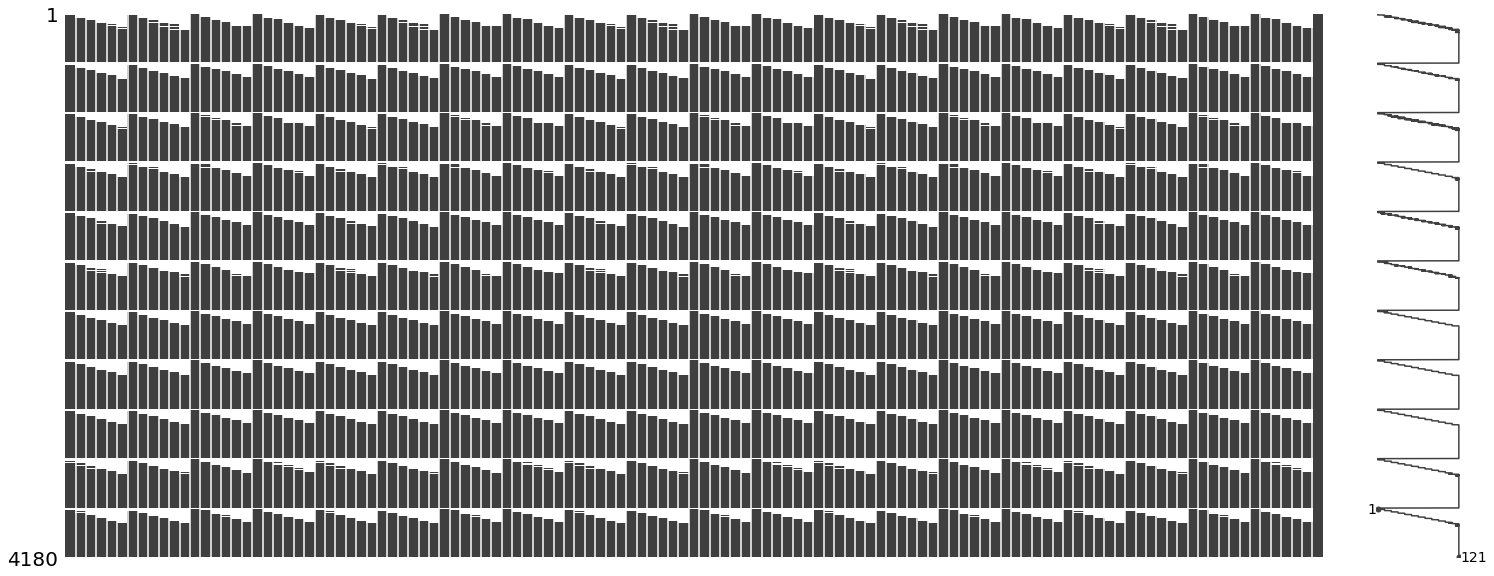

In [7]:
msno.matrix(df_cut)

plt.show();

### For a Single Feature - Sort in Sequence and View

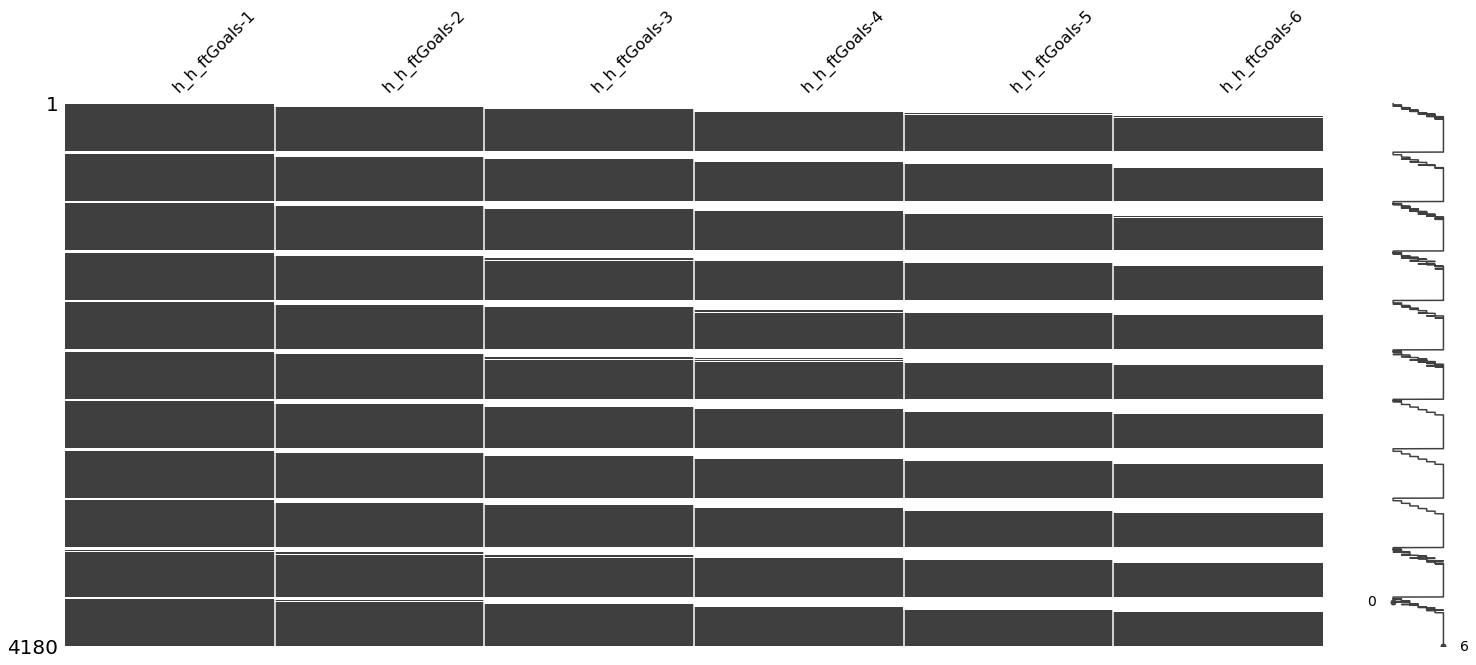

In [8]:
h_h_ftGoals_cols = ['h_h_ftGoals-' + str(n) for n in range(1, 7)]
msno.matrix(df_cut[h_h_ftGoals_cols])
plt.show()

In [9]:
# Drop all rows that have got any Nulls
df_cut2 = df_cut.dropna(subset=keeper_cols3).reset_index(drop=True)
df_cut2.head()

,h_h_ftGoals-1,h_h_ftGoals-2,h_h_ftGoals-3,h_h_ftGoals-4,h_h_ftGoals-5,h_h_ftGoals-6,a_a_ftGoals-1,a_a_ftGoals-2,a_a_ftGoals-3,a_a_ftGoals-4,a_a_ftGoals-5,a_a_ftGoals-6,a_h_ftGoals-1,a_h_ftGoals-2,a_h_ftGoals-3,a_h_ftGoals-4,a_h_ftGoals-5,a_h_ftGoals-6,h_a_ftGoals-1,h_a_ftGoals-2,h_a_ftGoals-3,h_a_ftGoals-4,h_a_ftGoals-5,h_a_ftGoals-6,h_h_shots-1,h_h_shots-2,h_h_shots-3,h_h_shots-4,h_h_shots-5,h_h_shots-6,a_a_shots-1,a_a_shots-2,a_a_shots-3,a_a_shots-4,a_a_shots-5,a_a_shots-6,a_h_shots-1,a_h_shots-2,a_h_shots-3,a_h_shots-4,a_h_shots-5,a_h_shots-6,h_a_shots-1,h_a_shots-2,h_a_shots-3,h_a_shots-4,h_a_shots-5,h_a_shots-6,h_h_shotsOnTarget-1,h_h_shotsOnTarget-2,h_h_shotsOnTarget-3,h_h_shotsOnTarget-4,h_h_shotsOnTarget-5,h_h_shotsOnTarget-6,a_a_shotsOnTarget-1,a_a_shotsOnTarget-2,a_a_shotsOnTarget-3,a_a_shotsOnTarget-4,a_a_shotsOnTarget-5,a_a_shotsOnTarget-6,a_h_shotsOnTarget-1,a_h_shotsOnTarget-2,a_h_shotsOnTarget-3,a_h_shotsOnTarget-4,a_h_shotsOnTarget-5,a_h_shotsOnTarget-6,h_a_shotsOnTarget-1,h_a_shotsOnTarget-2,h_a_shotsOnTarget-3,h_a_shotsOnTarget-4,h_a_shotsOnTarget-5,h_a_shotsOnTarget-6,h_h_oddsWinMean-1,h_h_oddsWinMean-2,h_h_oddsWinMean-3,h_h_oddsWinMean-4,h_h_oddsWinMean-5,h_h_oddsWinMean-6,a_a_oddsWinMean-1,a_a_oddsWinMean-2,a_a_oddsWinMean-3,a_a_oddsWinMean-4,a_a_oddsWinMean-5,a_a_oddsWinMean-6,a_h_oddsWinMean-1,a_h_oddsWinMean-2,a_h_oddsWinMean-3,a_h_oddsWinMean-4,a_h_oddsWinMean-5,a_h_oddsWinMean-6,h_a_oddsWinMean-1,h_a_oddsWinMean-2,h_a_oddsWinMean-3,h_a_oddsWinMean-4,h_a_oddsWinMean-5,h_a_oddsWinMean-6,h_h_oddsDrawMean-1,h_h_oddsDrawMean-2,h_h_oddsDrawMean-3,h_h_oddsDrawMean-4,h_h_oddsDrawMean-5,h_h_oddsDrawMean-6,a_a_oddsDrawMean-1,a_a_oddsDrawMean-2,a_a_oddsDrawMean-3,a_a_oddsDrawMean-4,a_a_oddsDrawMean-5,a_a_oddsDrawMean-6,a_h_oddsDrawMean-1,a_h_oddsDrawMean-2,a_h_oddsDrawMean-3,a_h_oddsDrawMean-4,a_h_oddsDrawMean-5,a_h_oddsDrawMean-6,h_a_oddsDrawMean-1,h_a_oddsDrawMean-2,h_a_oddsDrawMean-3,h_a_oddsDrawMean-4,h_a_oddsDrawMean-5,h_a_oddsDrawMean-6,result
0,1.0,0.0,1.0,1.0,3.0,1.0,1.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,2.0,2.0,2.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,13.0,13.0,5.0,13.0,18.0,13.0,7.0,17.0,13.0,16.0,9.0,5.0,5.0,7.0,16.0,13.0,11.0,10.0,11.0,1.0,12.0,8.0,8.0,14.0,6.0,7.0,4.0,7.0,12.0,9.0,4.0,11.0,5.0,12.0,6.0,1.0,3.0,4.0,5.0,7.0,7.0,6.0,6.0,0.0,7.0,3.0,3.0,7.0,2.56,4.88,2.76,2.39,2.24,2.41,14.34,5.22,4.45,3.70,3.38,2.91,2.76,5.31,2.03,2.00,2.56,2.41,4.15,12.05,2.62,2.82,4.09,3.04,3.18,3.44,3.20,3.20,3.21,3.18,5.75,3.43,3.35,3.25,3.25,3.20,3.21,3.51,3.21,3.26,3.16,3.18,3.28,5.29,3.19,3.20,3.28,3.22,draw
1,0.0,1.0,0.0,1.0,1.0,3.0,2.0,4.0,1.0,1.0,0.0,1.0,2.0,4.0,4.0,2.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,15.0,13.0,13.0,5.0,13.0,18.0,10.0,21.0,11.0,16.0,15.0,20.0,22.0,18.0,17.0,17.0,17.0,14.0,11.0,1.0,12.0,8.0,8.0,14.0,7.0,6.0,7.0,4.0,7.0,12.0,4.0,13.0,4.0,8.0,6.0,12.0,15.0,14.0,12.0,9.0,9.0,5.0,6.0,0.0,7.0,3.0,3.0,7.0,2.07,2.56,4.88,2.76,2.39,2.24,2.86,1.76,1.51,1.80,1.88,1.61,1.34,1.19,1.17,2.00,1.20,1.51,4.15,12.05,2.62,2.82,4.09,3.04,3.24,3.18,3.44,3.20,3.20,3.21,3.13,3.37,3.74,3.34,3.25,3.51,4.40,5.75,6.05,3.17,5.69,3.77,3.28,5.29,3.19,3.20,3.28,3.22,hwin
2,0.0,0.0,1.0,1.0,1.0,2.0,2.0,2.0,1.0,0.0,0.0,1.0,1.0,6.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,5.0,10.0,10.0,16.0,12.0,13.0,9.0,15.0,4.0,20.0,6.0,15.0,16.0,16.0,16.0,18.0,19.0,8.0,13.0,7.0,4.0,8.0,4.0,2.0,2.0,6.0,3.0,8.0,5.0,7.0,6.0,8.0,1.0,8.0,2.0,10.0,9.0,4.0,8.0,7.0,11.0,2.0,9.0,0.0,3.0,3.0,2.0,3.15,3.26,2.57,4.09,2.38,2.85,1.41,1.64,1.70,3.70,1.66,2.88,1.34,1.49,1.31,1.37,1.28,1.19,7.80,4.93,4.85,16.55,14.68,7.33,3.22,3.19,3.19,3.31,3.18,3.19,4.05,3.51,3.44,3.17,3.43,3.06,4.37,3.77,4.67,4.23,4.74,5.74,4.01,3.43,3.39,6.12,5.90,3.91,awin
3,1.0,3.0,0.0,1.0,0.0,2.0,4.0,2.0,2.0,1.0,1.0,0.0,0.0,0.0,7.0,0.0,3.0,1.0,1.0,0.0,1.0,0.0,0.0,2.0,13.0,16.0,17.0,10.0,6.0,7.0,10.0,15.0,14.0,13.0,15.0,18.0,20.0,10.0,25.0,9.0,11.0,7.0,7.0,13.0,6.0,5.0,9.0,11.0,8.0,10.0,9.0,5.0,3.0,3.0,7.0,8.0,8.0,7.0,10.0,4.0,12.0,3.0,17.0,2.0,6.0,6.0,6.0,8.0,5.0,2.0,4.0,6.0,2.62,2.06,6.40,2.38,

In [10]:
# Split into X, y
# Use to_categorical on your labels
X = df_cut2
y = df_cut2.pop('result')

In [11]:
# Split by Train, Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [12]:
X_train.head()

,h_h_ftGoals-1,h_h_ftGoals-2,h_h_ftGoals-3,h_h_ftGoals-4,h_h_ftGoals-5,h_h_ftGoals-6,a_a_ftGoals-1,a_a_ftGoals-2,a_a_ftGoals-3,a_a_ftGoals-4,a_a_ftGoals-5,a_a_ftGoals-6,a_h_ftGoals-1,a_h_ftGoals-2,a_h_ftGoals-3,a_h_ftGoals-4,a_h_ftGoals-5,a_h_ftGoals-6,h_a_ftGoals-1,h_a_ftGoals-2,h_a_ftGoals-3,h_a_ftGoals-4,h_a_ftGoals-5,h_a_ftGoals-6,h_h_shots-1,h_h_shots-2,h_h_shots-3,h_h_shots-4,h_h_shots-5,h_h_shots-6,a_a_shots-1,a_a_shots-2,a_a_shots-3,a_a_shots-4,a_a_shots-5,a_a_shots-6,a_h_shots-1,a_h_shots-2,a_h_shots-3,a_h_shots-4,a_h_shots-5,a_h_shots-6,h_a_shots-1,h_a_shots-2,h_a_shots-3,h_a_shots-4,h_a_shots-5,h_a_shots-6,h_h_shotsOnTarget-1,h_h_shotsOnTarget-2,h_h_shotsOnTarget-3,h_h_shotsOnTarget-4,h_h_shotsOnTarget-5,h_h_shotsOnTarget-6,a_a_shotsOnTarget-1,a_a_shotsOnTarget-2,a_a_shotsOnTarget-3,a_a_shotsOnTarget-4,a_a_shotsOnTarget-5,a_a_shotsOnTarget-6,a_h_shotsOnTarget-1,a_h_shotsOnTarget-2,a_h_shotsOnTarget-3,a_h_shotsOnTarget-4,a_h_shotsOnTarget-5,a_h_shotsOnTarget-6,h_a_shotsOnTarget-1,h_a_shotsOnTarget-2,h_a_shotsOnTarget-3,h_a_shotsOnTarget-4,h_a_shotsOnTarget-5,h_a_shotsOnTarget-6,h_h_oddsWinMean-1,h_h_oddsWinMean-2,h_h_oddsWinMean-3,h_h_oddsWinMean-4,h_h_oddsWinMean-5,h_h_oddsWinMean-6,a_a_oddsWinMean-1,a_a_oddsWinMean-2,a_a_oddsWinMean-3,a_a_oddsWinMean-4,a_a_oddsWinMean-5,a_a_oddsWinMean-6,a_h_oddsWinMean-1,a_h_oddsWinMean-2,a_h_oddsWinMean-3,a_h_oddsWinMean-4,a_h_oddsWinMean-5,a_h_oddsWinMean-6,h_a_oddsWinMean-1,h_a_oddsWinMean-2,h_a_oddsWinMean-3,h_a_oddsWinMean-4,h_a_oddsWinMean-5,h_a_oddsWinMean-6,h_h_oddsDrawMean-1,h_h_oddsDrawMean-2,h_h_oddsDrawMean-3,h_h_oddsDrawMean-4,h_h_oddsDrawMean-5,h_h_oddsDrawMean-6,a_a_oddsDrawMean-1,a_a_oddsDrawMean-2,a_a_oddsDrawMean-3,a_a_oddsDrawMean-4,a_a_oddsDrawMean-5,a_a_oddsDrawMean-6,a_h_oddsDrawMean-1,a_h_oddsDrawMean-2,a_h_oddsDrawMean-3,a_h_oddsDrawMean-4,a_h_oddsDrawMean-5,a_h_oddsDrawMean-6,h_a_oddsDrawMean-1,h_a_oddsDrawMean-2,h_a_oddsDrawMean-3,h_a_oddsDrawMean-4,h_a_oddsDrawMean-5,h_a_oddsDrawMean-6
1832,0.0,2.0,1.0,1.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,0.0,2.0,2.0,1.0,1.0,14.0,13.0,14.0,17.0,9.0,7.0,15.0,5.0,6.0,10.0,10.0,11.0,7.0,12.0,11.0,14.0,14.0,17.0,10.0,10.0,23.0,18.0,19.0,6.0,3.0,6.0,4.0,2.0,4.0,1.0,3.0,4.0,2.0,4.0,2.0,3.0,2.0,2.0,4.0,3.0,3.0,3.0,4.0,2.0,6.0,7.0,7.0,4.0,1.59,2.26,1.67,1.74,2.15,1.50,3.81,5.49,11.61,4.80,4.02,3.50,5.06,2.78,2.14,2.49,4.46,2.75,2.91,8.05,2.16,2.05,7.29,4.65,3.95,3.39,3.72,3.74,3.36,4.20,3.37,3.66,5.81,3.57,3.37,3.24,3.61,3.23,3.28,3.28,3.56,3.29,3.33,4.67,3.33,3.40,4.49,3.72
1334,1.0,2.0,1.0,1.0,0.0,2.0,3.0,1.0,0.0,1.0,2.0,5.0,4.0,1.0,1.0,3.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,2.0,14.0,11.0,12.0,10.0,11.0,10.0,16.0,14.0,21.0,9.0,12.0,10.0,22.0,26.0,24.0,22.0,20.0,23.0,4.0,1.0,6.0,12.0,8.0,8.0,8.0,5.0,3.0,5.0,6.0,5.0,8.0,9.0,14.0,5.0,5.0,6.0,12.0,17.0,11.0,11.0,12.0,13.0,2.0,0.0,4.0,6.0,3.0,6.0,3.00,1.96,2.14,1.90,1.96,1.90,2.43,2.93,2.11,3.85,2.74,1.77,1.53,1.37,1.40,1.46,1.55,1.35,5.89,2.97,3.64,3.74,2.74,10.92,3.20,3.36,3.32,3.40,3.32,3.40,3.23,3.38,3.43,3.50,3.24,3.63,4.00,4.61,4.59,4.33,4.05,4.92,3.72,3.19,3.31,3.34,3.24,5.35
2044,6.0,3.0,2.0,3.0,2.0,5.0,0.0,1.0,1.0,0.0,1.0,0.0,6.0,2.0,2.0,2.0,1.0,0.0,4.0,1.0,2.0,1.0,0.0,1.0,23.0,11.0,18.0,43.0,22.0,16.0,10.0,11.0,12.0,11.0,12.0,12.0,18.0,13.0,9.0,20.0,23.0,13.0,22.0,15.0,10.0,22.0,21.0,8.0,11.0,4.0,3.0,16.0,9.0,9.0,3.0,2.0,6.0,2.0,5.0,2.0,11.0,4.0,4.0,3.0,3.0,5.0,11.0,4.0,3.0,4.0,5.0,1.0,1.21,1.26,1.25,1.31,1.25,1.28,2.82,2.05,2.27,2.81,6.26,2.32,1.75,2.06,1.51,1.45,1.69,2.49,1.71,2.03,2.72,1.66,1.44,2.36,6.86,5.91,6.05,5.50,6.24,5.68,3.28,3.28,3.21,3.18,3.87,3.16,3.66,3.40,3.98,4.29,3.68,3.27,3.92,3.61,3.34,3.92,4.60,3.44
1999,2.0,2.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,2.0,2.0,3.0,0.0,4.0,3.0,2.0,2.0,2.0,1.0,0.0,1.0,0.0,1.0,2.0,9.0,20.0,23.0,13.0,21.0,15.0,14.0,12.0,5.0,13.0,14.0,14.0,14.0,10.0,20.0,27.0,23.0,25.0,12.0,11.0,12.0,12.0,16.0,5.0,4.0,3.0,3.0,5.0,7.0,6.0,8.0,2.0,1.0,6.0,5.0,4.0,3.0,4.0,7.0,8.0,8.0,8.0,6.0,2.0,5.0,2.0,5.0,3.0,1.51,1.45,1.69,2.49,1.7

In [13]:
y_train.head()

1832    hwin
1334    hwin
2044    hwin
1999    draw
238     hwin
Name: result, dtype: object

In [14]:
skf = StratifiedKFold(n_splits=5)

scaler = SelectiveMinMaxScaler()
xgb = XGBClassifier()

pipe = Pipeline([('scaler', scaler),
                ('xgb', xgb)])

scores = cross_val_score(pipe, X_train, y_train, cv=skf, scoring=rps_mean)

print(scores)
print(np.mean(scores))

[-0.19872123 -0.20630326 -0.20704203 -0.18692163 -0.20152687]
-0.20010300243319615
